## Plot map of hamburg with postal codes

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn') 

In [2]:
plz_shape_df = gpd.read_file('data/plz-gebiete.shp', dtype={'plz': str})
plz_shape_df = plz_shape_df[plz_shape_df.note.str.contains("Hamburg", na = False)]
plz_shape_df

AttributeError: 'GeoDataFrame' object has no attribute 'note'

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


,gml_id,bezirk,bezirk_nam,geometry
0,APP_BEZIRKE_995,1,Hamburg-Mitte,"MULTIPOLYGON (((567457.463 5925454.778, 567354..."
1,APP_BEZIRKE_996,2,Altona,"POLYGON ((556987.271 5933217.876, 556797.543 5..."
2,APP_BEZIRKE_997,3,Eimsbüttel,"POLYGON ((562579.576 5936283.323, 562577.901 5..."
3,APP_BEZIRKE_998,4,Hamburg-Nord,"POLYGON ((567183.046 5935287.830, 567174.751 5..."
4,APP_BEZIRKE_999,5,Wandsbek,"MULTIPOLYGON (((579200.493 5939722.449, 579204..."


<AxesSubplot:>

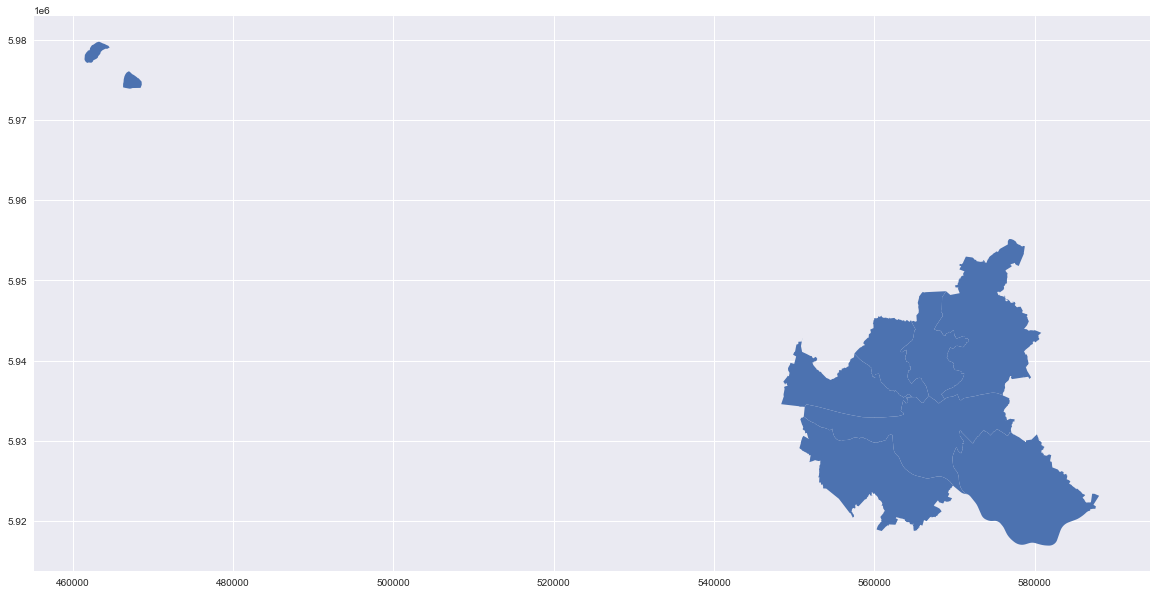

In [4]:
# Jaa, finally
test_sf = gpd.read_file('data/stadtteile/app_bezirke.shp', dtype={'plz': str})
fig, ax = plt.subplots(figsize = (20, 20))
print(type(test_sf))

#test_sf = test_sf[test_sf.GEN == "Hamburg"]
print(type(test_sf))
display(test_sf.head())
test_sf.plot(
    ax = ax
)


<class 'geopandas.geodataframe.GeoDataFrame'>


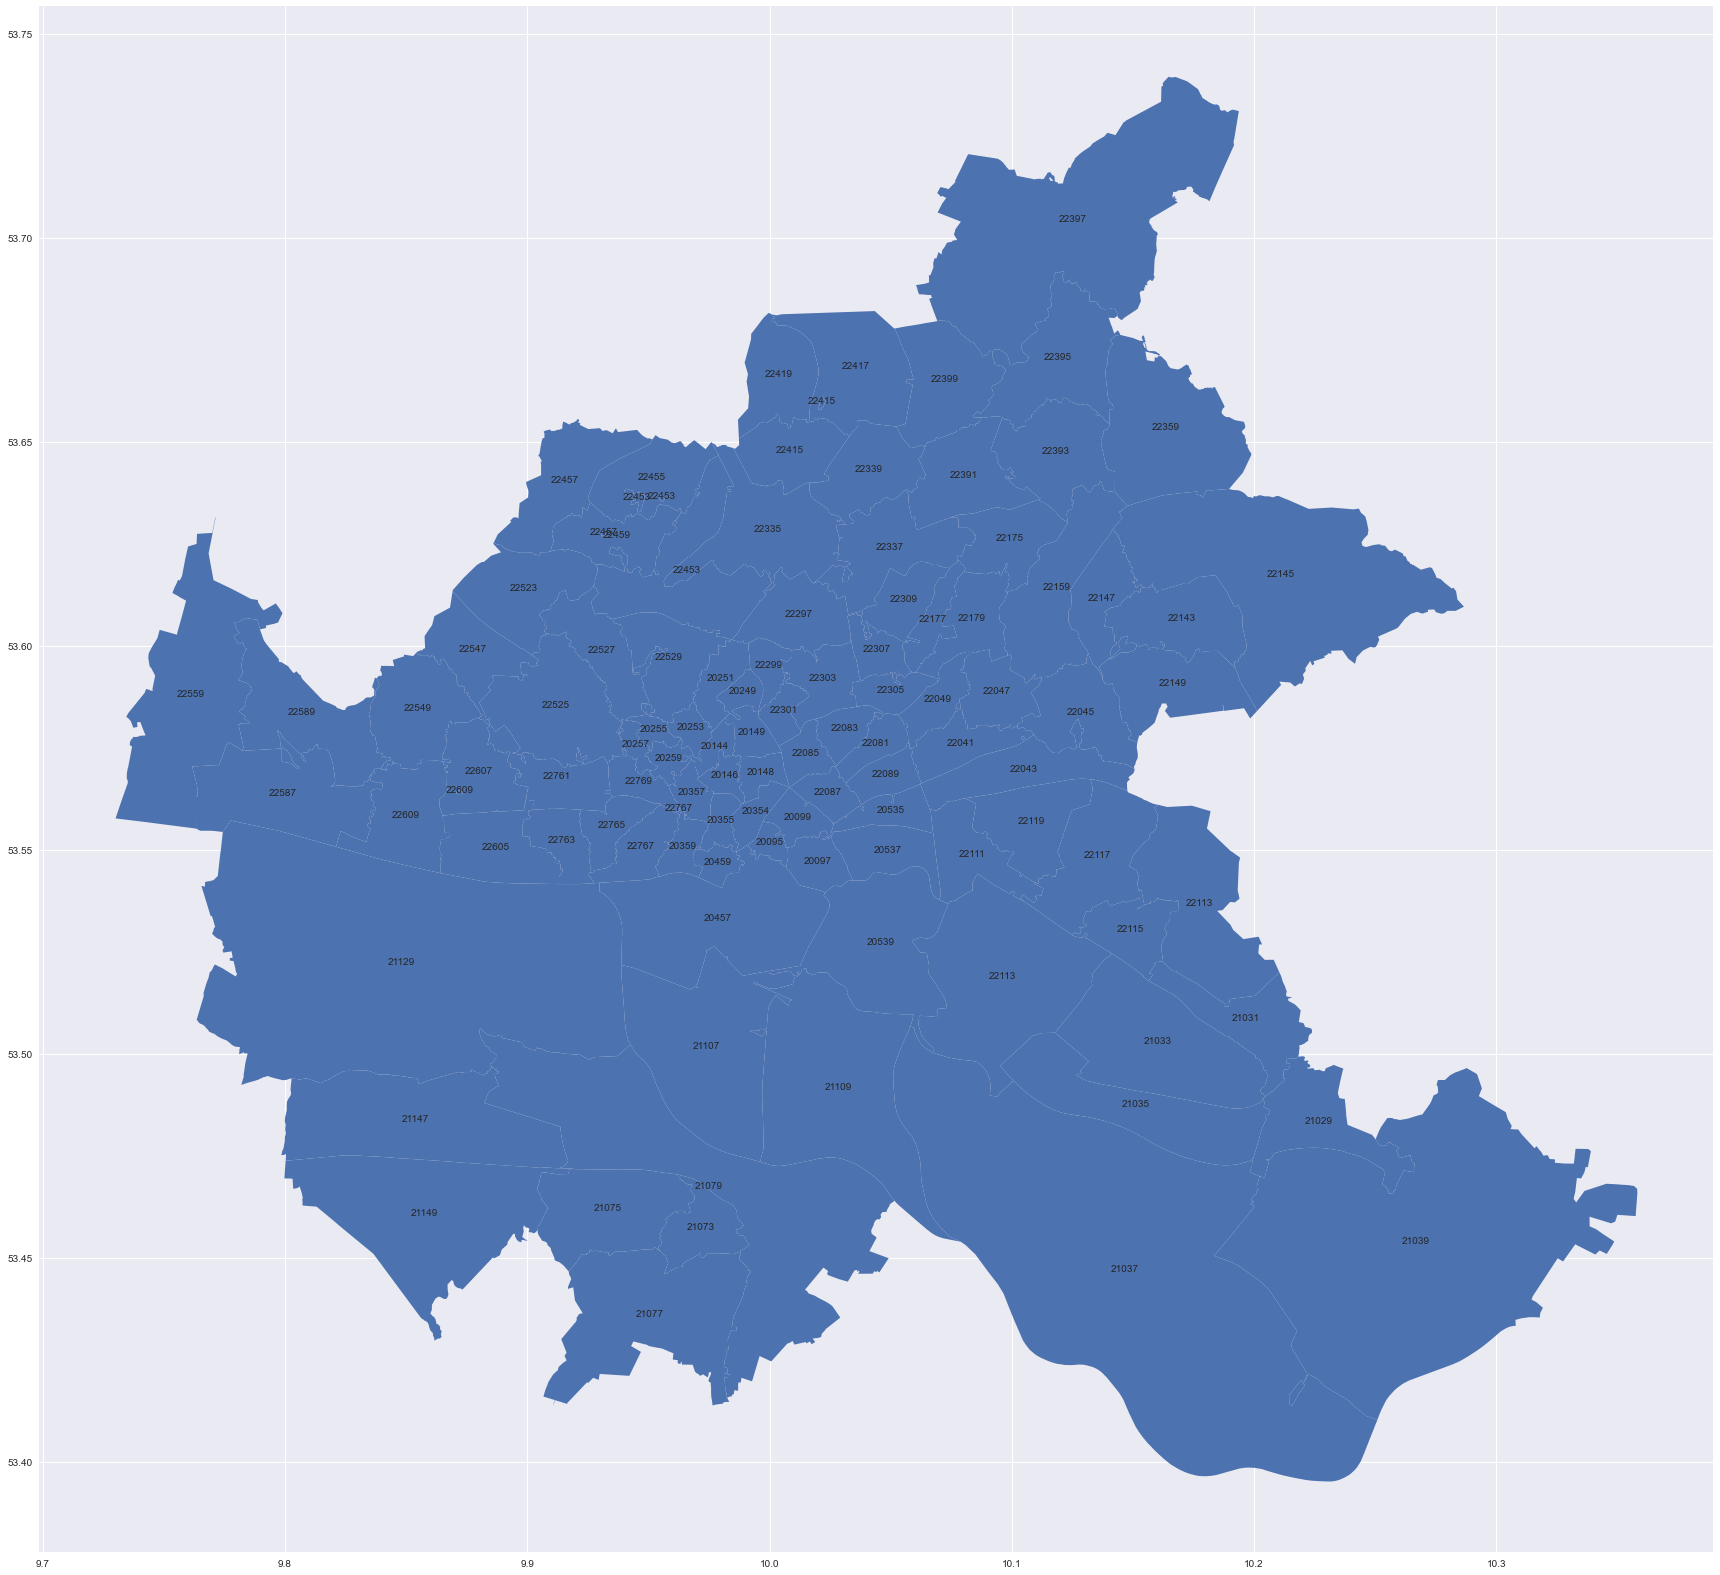

In [257]:
fig, ax = plt.subplots(figsize = (30, 30))
print(type(plz_shape_df))
plz_shape_df.plot(ax = ax)
plz_shape_df.apply(lambda x: ax.annotate(text=x.plz, xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
plz_shape_df.to_csv("shapefile_with_bezirke.csv")

104
106


,plz,Stadtteil
137,21129,Cranz


,plz,Stadtteil,note,geometry
20,21129,Altenwerder,21129 Hamburg,"POLYGON ((9.76358 53.50826, 9.76654 53.51414, ..."
21,21129,Cranz,21129 Hamburg,"POLYGON ((9.76358 53.50826, 9.76654 53.51414, ..."
22,21129,Finkenwerder,21129 Hamburg,"POLYGON ((9.76358 53.50826, 9.76654 53.51414, ..."
23,21129,Francop,21129 Hamburg,"POLYGON ((9.76358 53.50826, 9.76654 53.51414, ..."
24,21129,Moorburg,21129 Hamburg,"POLYGON ((9.76358 53.50826, 9.76654 53.51414, ..."
25,21129,Neuland,21129 Hamburg,"POLYGON ((9.76358 53.50826, 9.76654 53.51414, ..."
26,21129,Walstershof,21129 Hamburg,"POLYGON ((9.76358 53.50826, 9.76654 53.51414, ..."
27,21129,NaN,21129 Hamburg,"POLYGON ((9.76358 53.50826, 9.76654 53.51414, ..."
28,21129,NaN,21129 Hamburg,"POLYGON ((9.76358 53.50826, 9.76654 53.51414, ..."
29,21129,NaN,21129 Hamburg,"POLYGON ((9.76358 53.50826, 9.76654 53.51414, ..."


43


,Stadtteil,Bezirk,plz,note,geometry
0,Blankenese,Altona,22559,22559 Hamburg,"POLYGON ((9.73012 53.55764, 9.73301 53.56270, ..."
1,Blankenese,Altona,22587,22587 Hamburg,"POLYGON ((9.76176 53.57038, 9.77285 53.57073, ..."
2,Altenwerder,Harburg,21129,21129 Hamburg,"POLYGON ((9.76358 53.50826, 9.76654 53.51414, ..."
3,Blankenese,Altona,22589,22589 Hamburg,"POLYGON ((9.77885 53.60228, 9.78131 53.60316, ..."
4,Hausbruch,Harburg,21147,21147 Hamburg,"POLYGON ((9.79850 53.47513, 9.79874 53.47556, ..."


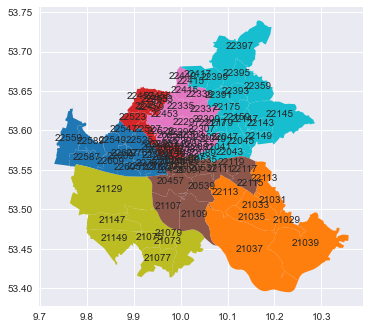

In [223]:
# Load all districts of hamburg with corresponding bezirke 
bezirke_df = pd.read_csv("data/zuordnung_bezirke.csv",header=None).iloc[:, 1:3]
bezirke_df = bezirke_df.rename(columns = {1:"Stadtteil", 2: "Bezirk"})
print(len(bezirke_df.Stadtteil.unique()))

# Then load postalcodes with the corresponding districts and pivot longer (open data in hamburg doesn't necessarily mean that you can download stuff)
postleitzahlen_df = pd.read_csv("data/Hamburg_PLZ.csv", header = None).rename(columns = {0:"plz"})
postleitzahlen_df = postleitzahlen_df.astype({'plz':'string'})
postleitzahlen_df = postleitzahlen_df.melt(id_vars='plz', value_vars = [1,2,3,4,5,6,7,8,9,10], value_name = "Stadtteil")[['plz', 'Stadtteil']]
print(len(postleitzahlen_df.Stadtteil.unique()))
display(postleitzahlen_df[postleitzahlen_df.Stadtteil == "Cranz"])

# Then join the postalcodes with the shapefile (keep only the matches on the geometry data) and drop duplicates
plz_stadtteil_df = pd.merge(postleitzahlen_df, plz_shape_df, on = ['plz', 'plz'],how='right')
display(plz_stadtteil_df[plz_stadtteil_df.plz == "21129"])
plz_stadtteil_df = plz_stadtteil_df.drop_duplicates(subset = ['geometry']).dropna()
print(len(plz_stadtteil_df.Stadtteil.unique()))


# then merge bezirke on the districts name
df = pd.merge(bezirke_df, plz_stadtteil_df, on=['Stadtteil', 'Stadtteil'], how = "right")

# Then cast Dataframe to GeoDataFrame and plot
fig, ax = plt.subplots()
geo_df = gpd.GeoDataFrame(df)
display(geo_df.head())
geo_df.plot(
    ax = ax,
    column = 'Bezirk'
)
geo_df.apply(lambda x: ax.annotate(text=x.plz, xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

In [214]:
pd.read_csv("data/stadtteile/stadtteile_koordinaten.csv")[["Stadtteil", "Bezirk", "Koordinaten"]]

,Stadtteil,Bezirk,Koordinaten
0,Hamburg-Altstadt,Hamburg-Mitte,"53° 33′ 0″ N, 10° 0′ 0″ O"
1,HafenCity,Hamburg-Mitte,"53° 32′ 28″ N, 10° 0′ 1″ O"
2,Neustadt,Hamburg-Mitte,"53° 33′ 7″ N, 9° 59′ 8″ O"
3,St. Pauli,Hamburg-Mitte,"53° 33′ 25″ N, 9° 57′ 50″ O"
4,St. Georg,Hamburg-Mitte,"53° 33′ 18″ N, 10° 0′ 44″ O"
...,...,...,...
99,Hausbruch,Harburg,"53° 28′ 0″ N, 9° 53′ 0″ O"
100,Neugraben-Fischbek,Harburg,"53° 29′ 0″ N, 9° 51′ 0″ O"
101,Francop,Harburg,"53° 30′ 29″ N, 9° 51′ 10″ O"
102,Neuenfelde,Harburg,"53° 30′ 53″ N, 9° 47′ 44″ O"


In [226]:
import folium
m = folium.Map(location=[45.5236, -122.6750])
m